## Import Libraries

In [2]:
!pip install contractions nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.7 MB/s eta 0:00:00


In [18]:
import pandas as pd
import re
import nltk
import random
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /home/omar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/omar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/omar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load Dataset


In [19]:
# Load the dataset
train_df = pd.read_parquet('datasets/tweet_eval_train.parquet')
val_df = pd.read_parquet('datasets/tweet_eval_val.parquet')
test_df = pd.read_parquet('datasets/tweet_eval_test.parquet')


### Get Some Insights From Data

In [20]:
train_df.head()

,text,label
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2


In [21]:
train_df['label'].value_counts()

label
1    20673
2    17849
0     7093
Name: count, dtype: int64

## Data Preprocessing

In [22]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Preprocess text by removing mentions, URLs, special characters, stop words, emojis,
    expanding contractions, correcting spelling, and lemmatizing.

    Args:
        text (str): Raw text data.

    Returns:
        str: Cleaned text data.
    """
    text = re.sub(r'(@\w+|http\S+)', '', text)
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    return text


### Applying Preprocessing on Data

In [23]:
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
val_df['cleaned_text'] = val_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

## Handling Imbalanced Data using Augmentation Using `nlpaug` Library

The nlpaug library provides a wide range of augmentation techniques beyond synonym replacement, contextual word embeddings insertion, and random word deletion

In [24]:
# def augment_data_minority(df, label_column, text_column, range_diff=1000):
#     """
#     Augment the minority class using simpler sequential augmentation until its count
#     becomes within range_diff from the majority class size.

#     Args:
#         df (pd.DataFrame): DataFrame containing the dataset.
#         label_column (str): The column name of the labels in the DataFrame.
#         text_column (str): The column name of the text data in the DataFrame.
#         range_diff (int): The acceptable range difference from the majority class size.

#     Returns:
#         pd.DataFrame: Augmented DataFrame.
#     """
#     augmented_data = []

#     label_counts = df[label_column].value_counts()
#     max_count = label_counts.max()
#     min_label = label_counts.idxmin()
#     min_count = label_counts.min()

#     # Define simpler sequential augmenters
#     augmenters = naf.Sequential([
#         naw.SynonymAug(aug_src='wordnet'),
#         naw.RandomWordAug(action="delete")
#     ])

#     df_label = df[df[label_column] == min_label]
#     while len(df_label) < max_count - range_diff:
#         augmented_texts = df_label[text_column].apply(lambda x: augmenters.augment(x))
#         augmented_data.append(pd.DataFrame({text_column: augmented_texts, label_column: min_label}))
#         df_label = pd.concat([df_label, augmented_data[-1]]).head(max_count - range_diff)

#     # Combine the original data with the augmented data
#     other_data = df[df[label_column] != min_label]
#     augmented_df = pd.concat([other_data, df_label]).reset_index(drop=True)

#     return augmented_df

# # Augment the training data
# augmented_train_df = augment_data_minority(train_df, 'label', 'cleaned_text')


In [25]:
def augment_data_all(df, label_column, text_column):
    """
    Augment the dataset using sequential augmentation for all classes to balance the dataset.

    Args:
        df (pd.DataFrame): DataFrame containing the dataset.
        label_column (str): The column name of the labels in the DataFrame.
        text_column (str): The column name of the text data in the DataFrame.

    Returns:
        pd.DataFrame: Augmented DataFrame.
    """
    augmented_data = []

    label_counts = df[label_column].value_counts()
    max_count = label_counts.max()
    print(f'max_count : {max_count} for labels with counts {label_counts}')

    # Define sequential augmenters
    augmenters = naf.Sequential([
        naw.SynonymAug(aug_src='wordnet'),
        naw.RandomWordAug(action='swap'),
        naw.RandomWordAug(action="delete")
    ])

    for label in label_counts.index:
        df_label = df[df[label_column] == label]
        initial_count = len(df_label)
        if initial_count < max_count:  # Only augment if current count is less than max_count
            print(f'Augment data of label : {label}')
            while len(df_label) < max_count:
                remaining_to_augment = max_count - len(df_label)
                augment_batch = min(remaining_to_augment, initial_count)
                augmented_texts = df_label[text_column].sample(augment_batch, replace=True).apply(lambda x: augmenters.augment(x))
                df_label = pd.concat([df_label, pd.DataFrame({text_column: augmented_texts, label_column: label})])
                df_label = df_label.head(max_count)
        augmented_data.append(df_label)

    augmented_df = pd.concat(augmented_data).reset_index(drop=True)
    return augmented_df



In [26]:
# Augment the training data
augmented_train_df = augment_data_all(train_df, 'label', 'cleaned_text')

max_count : 20673 for labels with counts label
1    20673
2    17849
0     7093
Name: count, dtype: int64
Augment data of label : 2
Augment data of label : 0


In [27]:
augmented_train_df['label'].value_counts()

label
1    20673
2    20673
0    20673
Name: count, dtype: int64

## Tokenization and Padding

In [28]:
# Tokenization
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(augmented_train_df['cleaned_text'])

X_train_sequences = tokenizer.texts_to_sequences(augmented_train_df['cleaned_text'])
X_val_sequences = tokenizer.texts_to_sequences(val_df['cleaned_text'])
X_test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Calculate sequence lengths
train_lengths = [len(seq) for seq in X_train_sequences]
val_lengths = [len(seq) for seq in X_val_sequences]
test_lengths = [len(seq) for seq in X_test_sequences]


### Plot Sequence Lengths and Calculate 98th Percentile

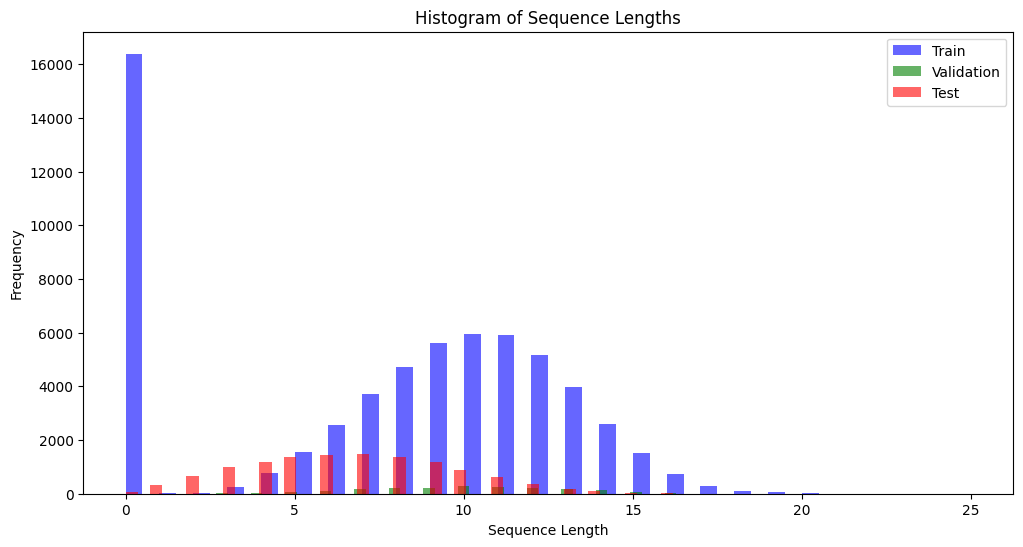

98th percentile of sequence lengths - Train: 15.0, Validation: 16.0, Test: 13.0
Selected max_len for padding: 16


In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Plot histogram of sequence lengths
plt.figure(figsize=(12, 6))
plt.hist(train_lengths, bins=50, alpha=0.6, color='b', label='Train')
plt.hist(val_lengths, bins=50, alpha=0.6, color='g', label='Validation')
plt.hist(test_lengths, bins=50, alpha=0.6, color='r', label='Test')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Sequence Lengths')
plt.show()

# Calculate 98th percentile length
max_len_train = np.percentile(train_lengths, 98)
max_len_val = np.percentile(val_lengths, 98)
max_len_test = np.percentile(test_lengths, 98)
max_len = int(max(max_len_train, max_len_val, max_len_test))

print(f'98th percentile of sequence lengths - Train: {max_len_train}, Validation: {max_len_val}, Test: {max_len_test}')
print(f'Selected max_len for padding: {max_len}')


### Padding / Truncating to a `98%` Of Data

In [30]:
# Padding/Truncating
X_train = pad_sequences(X_train_sequences, maxlen=max_len)
X_val = pad_sequences(X_val_sequences, maxlen=max_len)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)
y_train = augmented_train_df['label']
y_val = val_df['label']
y_test = test_df['label']

## Convert Data into datasets
Creating datasets using `tf.data.Dataset` with shuffling, batching, and prefetching ensures efficient data loading, improves model training performance by overlapping data preprocessing and model execution, and handles large datasets seamlessly. This approach optimizes memory usage and computational resources, leading to faster and more reliable training.
￼

In [31]:
# Convert to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Apply Shuffling, Batching, and Prefetching
batch_size = 32

# Shuffle, batch, and prefetch the datasets
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


In [32]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 16), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## First: Build the BiLSTM Model

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_bilstm_model(vocab_size, embedding_dim, max_len):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')

    # Embedding layer
    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_len)(input_ids)

    # BiLSTM layer
    lstm_layer = Bidirectional(LSTM(units=64, return_sequences=True))(embedding_layer)
    lstm_layer = Bidirectional(LSTM(units=32))(lstm_layer)

    # Fully connected layers with Dropout and Batch Normalization
    x = Dropout(0.5)(lstm_layer)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    output = Dense(3, activation='softmax')(x)  # Assuming 3 classes

    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=3e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Example usage
embedding_dim = 100  # Adjust as needed

model_1 = build_bilstm_model(max_features, embedding_dim, max_len)
model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 16)]              0         
                                                                 
 embedding (Embedding)       (None, 16, 100)           1000000   
                                                                 
 bidirectional (Bidirection  (None, 16, 128)           84480     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization (Batch  (None, 64)                256   

### Train The Model

In [ ]:
# Import custom helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, get_callbacks

lr_scheduler, early_stopping = get_callbacks()

# Train the model
history_1 = model_1.fit(train_dataset,
                        epochs=10,
                        validation_data=val_dataset,
                        callbacks=[create_tensorboard_callback(dir_name="models_logs", # save experiment logs here
                                                            experiment_name="model_1_bilstm"), lr_scheduler])


Saving TensorBoard log files to: models_logs/model_1_bilstm/20240720-224131
Epoch 1/10
1939/1939 [==============================] - 36s 15ms/step - loss: 2.0311 - accuracy: 0.4714 - val_loss: 1.7553 - val_accuracy: 0.4725 - lr: 3.0000e-05
Epoch 2/10
1939/1939 [==============================] - 20s 10ms/step - loss: 1.7441 - accuracy: 0.5202 - val_loss: 1.5845 - val_accuracy: 0.5260 - lr: 3.0000e-05
Epoch 3/10
1939/1939 [==============================] - 17s 9ms/step - loss: 1.5359 - accuracy: 0.5651 - val_loss: 1.4255 - val_accuracy: 0.5740 - lr: 3.0000e-05
Epoch 4/10
1939/1939 [==============================] - 19s 10ms/step - loss: 1.3551 - accuracy: 0.6124 - val_loss: 1.2885 - val_accuracy: 0.6235 - lr: 3.0000e-05
Epoch 5/10
1939/1939 [==============================] - 19s 10ms/step - loss: 1.2076 - accuracy: 0.6524 - val_loss: 1.1860 - val_accuracy: 0.6310 - lr: 3.0000e-05
Epoch 6/10
1939/1939 [==============================] - 18s 9ms/step - loss: 1.0901 - accuracy: 0.6809 - val_l

### Test The Model and PLotting Loss Curves

In [ ]:
# Import custom helper functions
import time

loss, accuracy = model_1.evaluate(test_dataset)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

 16/384 [>.............................] - ETA: 1s - loss: 1.1939 - accuracy: 0.5605

384/384 [==============================] - 2s 4ms/step - loss: 1.1864 - accuracy: 0.5452
Test Accuracy: 54.52%


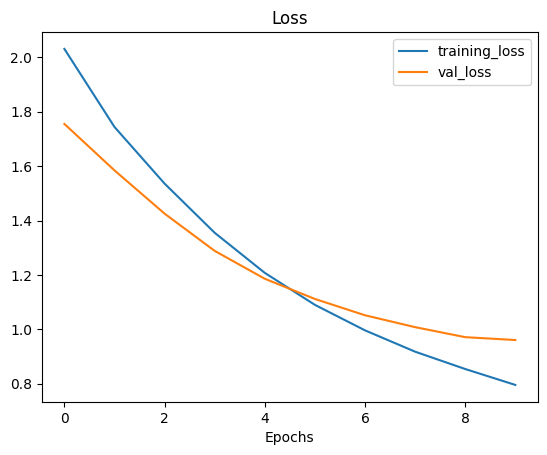

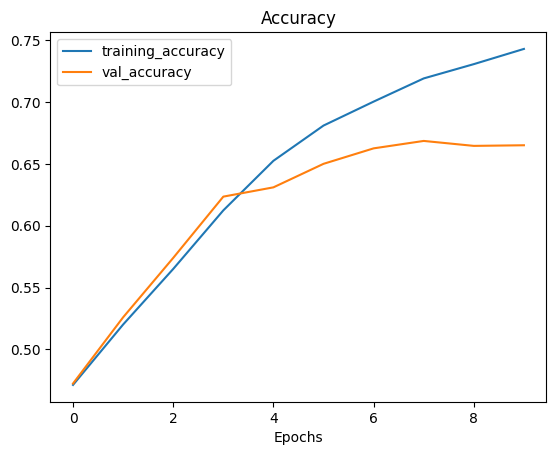

In [ ]:
plot_loss_curves(history_1)

## Second: Build the Word-Level CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_word_cnn_model(vocab_size, embedding_dim, max_len):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')

    # Embedding layer
    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_len)(input_ids)

    # Convolutional layer
    conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
    pooling_layer = GlobalMaxPooling1D()(conv_layer)

    # Fully connected layers with Dropout and Batch Normalization
    x = Dropout(0.5)(pooling_layer)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    output = Dense(3, activation='softmax')(x)  # Assuming 3 classes

    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=3e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

embedding_dim = 100
model_2 = build_word_cnn_model(max_features, embedding_dim, max_len)
model_2.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 16)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 16, 100)           1000000   
                                                                 
 conv1d_5 (Conv1D)           (None, 12, 128)           64128     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_14 (Ba  (None, 128)               512       
 tchNormalization)                                         

### Train The Model

In [ ]:
# Import custom helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, get_callbacks

lr_scheduler, early_stopping = get_callbacks()

# Train the model
history_2 = model_2.fit(train_dataset,
                        epochs=20,
                        validation_data=val_dataset,
                        callbacks=[create_tensorboard_callback(dir_name="models_logs", # save experiment logs here
                                                            experiment_name="model_2_word_cnn"), lr_scheduler])


Saving TensorBoard log files to: models_logs/model_2_word_cnn/20240720-225604
Epoch 1/20


1939/1939 [==============================] - 25s 12ms/step - loss: 2.4805 - accuracy: 0.4768 - val_loss: 2.1474 - val_accuracy: 0.4465 - lr: 3.0000e-05
Epoch 2/20
1939/1939 [==============================] - 11s 6ms/step - loss: 2.1715 - accuracy: 0.5064 - val_loss: 1.9671 - val_accuracy: 0.4580 - lr: 3.0000e-05
Epoch 3/20
1939/1939 [==============================] - 11s 5ms/step - loss: 1.9501 - accuracy: 0.5148 - val_loss: 1.8157 - val_accuracy: 0.4765 - lr: 3.0000e-05
Epoch 4/20
1939/1939 [==============================] - 11s 5ms/step - loss: 1.7640 - accuracy: 0.5296 - val_loss: 1.6806 - val_accuracy: 0.5080 - lr: 3.0000e-05
Epoch 5/20
1939/1939 [==============================] - 9s 5ms/step - loss: 1.6115 - accuracy: 0.5397 - val_loss: 1.5548 - val_accuracy: 0.5360 - lr: 3.0000e-05
Epoch 6/20
1939/1939 [==============================] - 10s 5ms/step - loss: 1.4693 - accuracy: 0.5568 - val_loss: 1.4344 - val_accuracy: 0.5505 - lr: 3.0000e-05
Epoch 7/20
1939/1939 [=================

### Testing The Model

In [ ]:
# Import custom helper functions
import time

loss, accuracy = model_2.evaluate(test_dataset)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

384/384 [==============================] - 1s 2ms/step - loss: 1.1697 - accuracy: 0.5318
Test Accuracy: 53.18%


### PLotting Loss Curves

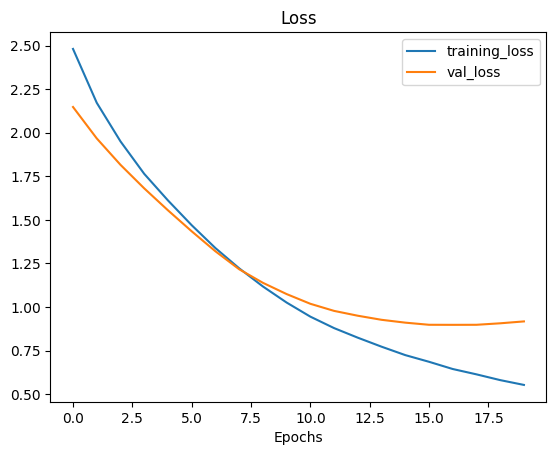

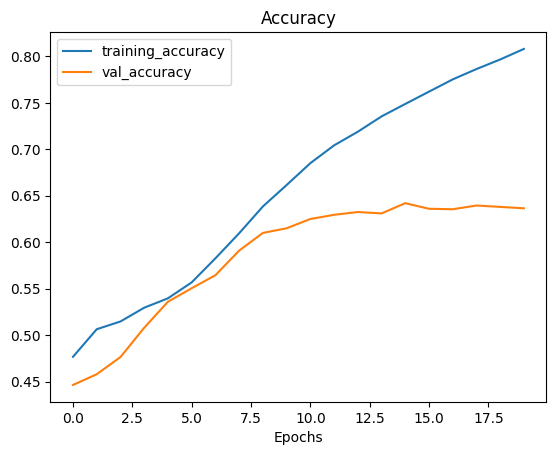

In [ ]:
plot_loss_curves(history_2)

## Third: Building the Transformer Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def build_transformer_model(vocab_size, embed_dim, num_heads, ff_dim, maxlen):
    inputs = tf.keras.layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(20, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

vocab_size = max_features
embed_dim = 100
num_heads = 4  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
maxlen = max_len

model_3 = build_transformer_model(vocab_size, embed_dim, num_heads, ff_dim, maxlen)
model_3.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 token_and_position_embeddi  (None, 16, 100)           1001600   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 16, 100)           187528    
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 100)               0     

### Training the Transformer Model

In [ ]:
# Import custom helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, get_callbacks

lr_scheduler, early_stopping = get_callbacks()

# Train the model
history_3 = model_3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[create_tensorboard_callback(dir_name="models_logs", # save experiment logs here
                                            experiment_name="model_3_custom_transformer"), lr_scheduler]
)


Saving TensorBoard log files to: models_logs/model_3_custom_transformer/20240720-233450


2024-07-20 23:34:51.251055: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/10


2024-07-20 23:34:54.308973: I external/local_xla/xla/service/service.cc:168] XLA service 0x788695be7410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-20 23:34:54.308995: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-07-20 23:34:54.324943: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-20 23:34:54.363142: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1721507694.447195    5486 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1939/1939 [==============================] - 32s 14ms/step - loss: 0.8255 - accuracy: 0.6116 - val_loss: 0.8037 - val_accuracy: 0.6415 - lr: 1.0000e-04
Epoch 2/10
1939/1939 [==============================] - 13s 7ms/step - loss: 0.6755 - accuracy: 0.7108 - val_loss: 0.7558 - val_accuracy: 0.6620 - lr: 1.0000e-04
Epoch 3/10
1939/1939 [==============================] - 13s 6ms/step - loss: 0.6158 - accuracy: 0.7413 - val_loss: 0.7621 - val_accuracy: 0.6625 - lr: 1.0000e-04
Epoch 4/10
1939/1939 [==============================] - 12s 6ms/step - loss: 0.5827 - accuracy: 0.7575 - val_loss: 0.7915 - val_accuracy: 0.6540 - lr: 1.0000e-04
Epoch 5/10
1939/1939 [==============================] - 12s 6ms/step - loss: 0.5554 - accuracy: 0.7694 - val_loss: 0.7984 - val_accuracy: 0.6595 - lr: 1.0000e-04
Epoch 6/10
1939/1939 [==============================] - 15s 8ms/step - loss: 0.5092 - accuracy: 0.7885 - val_loss: 0.8642 - val_accuracy: 0.6475 - lr: 5.0000e-05
Epoch 7/10
1939/1939 [================

### Testing The Model

In [ ]:
# Import custom helper functions
import time

loss, accuracy = model_3.evaluate(test_dataset)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

384/384 [==============================] - 1s 4ms/step - loss: 1.5486 - accuracy: 0.5532
Test Accuracy: 55.32%


## Fourth: Enhanced Transformer Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, embedding_matrix=None):
        super(TokenAndPositionEmbedding, self).__init__()
        if embedding_matrix is not None:
            self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[embedding_matrix], trainable=False)
        else:
            self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def build_enhanced_transformer_model(vocab_size, embed_dim, num_heads, ff_dim, maxlen, embedding_matrix=None):
    inputs = tf.keras.layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim, embedding_matrix)
    x = embedding_layer(inputs)
    for _ in range(2):  # Increase the number of Transformer blocks
        transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        x = transformer_block(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(3, activation="softmax")(x)  # Assuming 3 classes

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=3e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



vocab_size = max_features
embed_dim = 100
num_heads = 8  # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside transformer
maxlen = max_len

model_4 = build_enhanced_transformer_model(vocab_size, embed_dim, num_heads, ff_dim, maxlen)
model_4.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16)]              0         
                                                                 
 token_and_position_embeddi  (None, 16, 100)           1001600   
 ng_3 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_5 (Trans  (None, 16, 100)           374456    
 formerBlock)                                                    
                                                                 
 transformer_block_6 (Trans  (None, 16, 100)           374456    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_3  (None, 100)               0   

### Train The Model

In [ ]:
# Train the model
history_4 = model_4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size = 64,
    epochs=10,
    callbacks=[create_tensorboard_callback(dir_name="models_logs", # save experiment logs here
                                            experiment_name="model_4_enhanced_transformer")])

# # Plot the training history
# plot_loss_curves(history)

# # Evaluate the model
# accuracy, avg_inference_time = evaluate_model(model, test_dataset)  # Assuming test_dataset is already created
# print(f"Test Accuracy: {accuracy * 100:.2f}%")
# print(f"Average Inference Time per Sample: {avg_inference_time:.6f} seconds")

Saving TensorBoard log files to: models_logs/model_4_enhanced_transformer/20240721-002312
Epoch 1/10
970/970 [==============================] - 37s 34ms/step - loss: 0.9058 - accuracy: 0.5400 - val_loss: 0.9921 - val_accuracy: 0.4970
Epoch 2/10
970/970 [==============================] - 16s 17ms/step - loss: 0.8068 - accuracy: 0.6328 - val_loss: 0.8481 - val_accuracy: 0.6060
Epoch 3/10
970/970 [==============================] - 16s 17ms/step - loss: 0.7159 - accuracy: 0.6865 - val_loss: 0.7984 - val_accuracy: 0.6370
Epoch 4/10
970/970 [==============================] - 17s 17ms/step - loss: 0.6654 - accuracy: 0.7167 - val_loss: 0.7820 - val_accuracy: 0.6450
Epoch 5/10
970/970 [==============================] - 16s 16ms/step - loss: 0.6276 - accuracy: 0.7378 - val_loss: 0.7657 - val_accuracy: 0.6625
Epoch 6/10
970/970 [==============================] - 16s 16ms/step - loss: 0.6023 - accuracy: 0.7517 - val_loss: 0.7671 - val_accuracy: 0.6570
Epoch 7/10
970/970 [==========================

## Fifth: Try Using Pertained Model `Universal Sentence Encoder (USE)`

A model trained to encode sentences into high-dimensional vectors, useful for many NLP tasks.

### Load `universal_sentence_encoder`



In [18]:
import tensorflow_hub as hub


universal_sentence_encoder = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-large/5',
                                           input_shape=[], # shape of inputs coming to our mod
                                           dtype=tf.string, # data type of inputs coming to th
                                           trainable=False, # keep the pretrained weights (we'
                                           name="USE")

In [43]:
# Create a model
model_5 = tf.keras.models.Sequential([universal_sentence_encoder,
                                      tf.keras.layers.Dense(256, activation='relu'),
                                      tf.keras.layers.Dropout(0.5),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Dense(128, activation='relu'),
                                      tf.keras.layers.Dropout(0.5),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Dense(3, activation='softmax')], name="universal_sentence_encoder")

# Compile the model
model_5.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

### Preporcessing Data For Model

In [35]:
# Get train, test, val data

train_data = train_df["cleaned_text"].to_numpy()
train_label = train_df["label"].to_numpy()

val_data = val_df["cleaned_text"].to_numpy()
val_label = val_df['label'].to_numpy()

test_data = test_df["cleaned_text"].to_numpy()
test_label = test_df['label'].to_numpy()

In [36]:
# Getting the average number of words present in the sentences
sentence_len = [len(sentence.split()) for sentence in train_data]
average_sentence_len = round(sum(sentence_len) / len(sentence_len))

# Getting the 95% value of the tokens
np.percentile(sentence_len, 95), average_sentence_len

(16.0, 11)

### Make `TextVectorization` on Our Data
To Preprocess data and also be ready for the model

In [37]:
max_tokens = 10000
max_length = 16 # Covering the 95% of the sentence length

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,
                                                    output_sequence_length=max_length,
                                                    standardize="lower_and_strip_punctuation",
                                                    split="whitespace",
                                                    output_mode="int")

# Adapting the text_vectorization layer
text_vectorizer.adapt(train_data)
text_vectorizer.adapt(test_data)
text_vectorizer.adapt(val_data)

### Convert Vectorized data to `tf.data.Dataset`




In [40]:
# Convert to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_label))

# Apply Shuffling, Batching, and Prefetching
batch_size = 32

# Shuffle, batch, and prefetch the datasets
train_dataset = train_dataset.shuffle(buffer_size=len(train_data)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


### Train The Model

In [44]:
# Import custom helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, get_callbacks


# Modify the training process to include preprocessing
history_5 = model_5.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=15,
                        callbacks=[create_tensorboard_callback(dir_name="models_logs",
                                                                experiment_name="model_5_use")])

Saving TensorBoard log files to: models_logs/model_5_use/20240721-005116
Epoch 1/15
1426/1426 [==============================] - 90s 55ms/step - loss: 0.8992 - accuracy: 0.5808 - val_loss: 0.7483 - val_accuracy: 0.6580
Epoch 2/15
1426/1426 [==============================] - 75s 53ms/step - loss: 0.7749 - accuracy: 0.6411 - val_loss: 0.7466 - val_accuracy: 0.6610
Epoch 3/15
1426/1426 [==============================] - 73s 51ms/step - loss: 0.7593 - accuracy: 0.6523 - val_loss: 0.7420 - val_accuracy: 0.6665
Epoch 4/15
1426/1426 [==============================] - 73s 51ms/step - loss: 0.7455 - accuracy: 0.6596 - val_loss: 0.7359 - val_accuracy: 0.6640
Epoch 5/15
1426/1426 [==============================] - 72s 50ms/step - loss: 0.7356 - accuracy: 0.6659 - val_loss: 0.7344 - val_accuracy: 0.6610
Epoch 6/15
1426/1426 [==============================] - 71s 50ms/step - loss: 0.7252 - accuracy: 0.6706 - val_loss: 0.7324 - val_accuracy: 0.6635
Epoch 7/15
1426/1426 [=============================

## Sixth: Build Hybrid CNN-LSTM Model

In [58]:
def build_model(max_features, embedding_dim, max_len):
    """
    Build and compile a hybrid CNN-LSTM model.

    Args:
        max_features (int): Size of the vocabulary.
        embedding_dim (int): Dimension of the embedding vectors.
        max_len (int): Maximum length of input sequences.

    Returns:
        Sequential: Compiled Keras model.
    """
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_len))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

embedding_dim = 100
model_6 = build_model(max_features, embedding_dim, max_len)
model_6.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 16, 100)           1000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 128)           64128     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 6, 128)            0         
 g1D)                                                            
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dropout_27 (Dropout)        (None, 64)               

### Train The Model

In [59]:
# Import custom helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, get_callbacks

lr_scheduler, early_stopping = get_callbacks()

# Train the model
history_6 = model_6.fit(train_dataset,
                        epochs=10,
                        validation_data=val_dataset,
                        callbacks=[create_tensorboard_callback(dir_name="models_logs", # save experiment logs here
                                                            experiment_name="model_6_cnn_bilstm")])


Saving TensorBoard log files to: models_logs/model_6_cnn_bilstm/20240721-043254
Epoch 1/10


1939/1939 [==============================] - 32s 14ms/step - loss: 0.7526 - accuracy: 0.6657 - val_loss: 0.7565 - val_accuracy: 0.6740
Epoch 2/10
1939/1939 [==============================] - 12s 6ms/step - loss: 0.6271 - accuracy: 0.7390 - val_loss: 0.7550 - val_accuracy: 0.6605
Epoch 3/10
1939/1939 [==============================] - 14s 7ms/step - loss: 0.5072 - accuracy: 0.7985 - val_loss: 0.8997 - val_accuracy: 0.6450
Epoch 4/10
1939/1939 [==============================] - 15s 8ms/step - loss: 0.3612 - accuracy: 0.8627 - val_loss: 1.1328 - val_accuracy: 0.6265
Epoch 5/10
1939/1939 [==============================] - 15s 8ms/step - loss: 0.2572 - accuracy: 0.9050 - val_loss: 1.6328 - val_accuracy: 0.6220
Epoch 6/10
1939/1939 [==============================] - 15s 8ms/step - loss: 0.2053 - accuracy: 0.9259 - val_loss: 2.0057 - val_accuracy: 0.6055
Epoch 7/10
1939/1939 [==============================] - 12s 6ms/step - loss: 0.1787 - accuracy: 0.9352 - val_loss: 2.3200 - val_accuracy: 0.

### PLotting Loss Curves

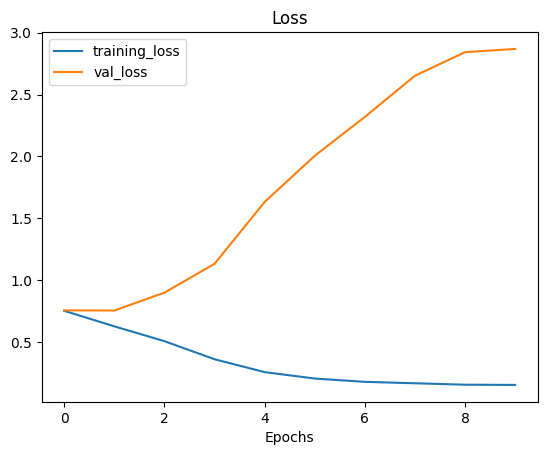

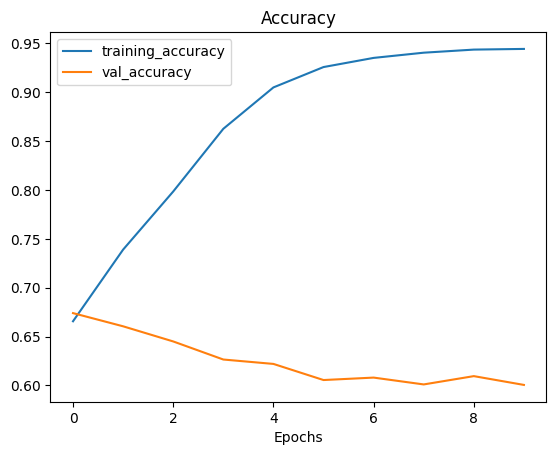

In [60]:
plot_loss_curves(history_6)

## Seventh: Build Different Architecture with Regularization and Pre-trained Embeddings

### Download Pre-trained Embeddings `GloVe Embeddings`

In [ ]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2024-07-20 14:33:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2024-07-20 14:36:34 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


### Load and Use GloVe

In [33]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

def load_glove_embeddings(tokenizer, embedding_dim, glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

# extracted the GloVe file
glove_file_path = 'glove.6B.100d.txt'
embedding_dim = 100
embedding_matrix = load_glove_embeddings(tokenizer, embedding_dim, glove_file_path)


### Build the Model with Pre-trained Embeddings

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

def build_model_with_pretrained_embeddings(max_features, embedding_dim, max_len, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))  # Set trainable to False to use pre-trained embeddings
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

embedding_dim = 100
model_7 = build_model_with_pretrained_embeddings(max_features, embedding_dim, max_len, embedding_matrix)
model_7.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           6112500   
                                                                 
 spatial_dropout1d (Spatial  (None, 16, 100)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 12, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 6, 128)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 6, 128)            98816     
 al)                                                             
                                                        

### Train The model

In [ ]:
# Train the model
history_7 = model_7.fit(train_dataset,
                        epochs=10,
                        validation_data=val_dataset,
                        callbacks=[create_tensorboard_callback(dir_name="models_logs", # save experiment logs here
                                                            experiment_name="model_7_pretraind_embeddings"), lr_scheduler])


Saving TensorBoard log files to: models_logs/model_2_pretraind_embeddings/20240720-143957
Epoch 1/10
1939/1939 [==============================] - 59s 24ms/step - loss: 0.7914 - accuracy: 0.6351 - val_loss: 0.8228 - val_accuracy: 0.6100 - lr: 0.0010
Epoch 2/10
1939/1939 [==============================] - 35s 18ms/step - loss: 0.7410 - accuracy: 0.6673 - val_loss: 0.8020 - val_accuracy: 0.6365 - lr: 0.0010
Epoch 3/10
1939/1939 [==============================] - 31s 16ms/step - loss: 0.7151 - accuracy: 0.6827 - val_loss: 0.8005 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 4/10
1939/1939 [==============================] - 31s 16ms/step - loss: 0.6926 - accuracy: 0.6950 - val_loss: 0.8032 - val_accuracy: 0.6445 - lr: 0.0010
Epoch 5/10
1939/1939 [==============================] - 35s 18ms/step - loss: 0.6721 - accuracy: 0.7090 - val_loss: 0.8069 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 6/10
1939/1939 [==============================] - 48s 25ms/step - loss: 0.6514 - accuracy: 0.7176 - val_loss:

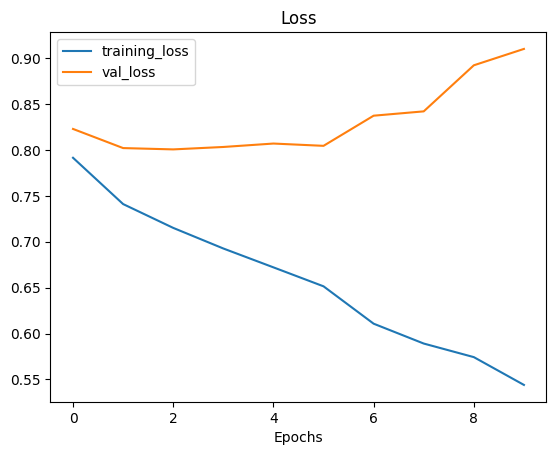

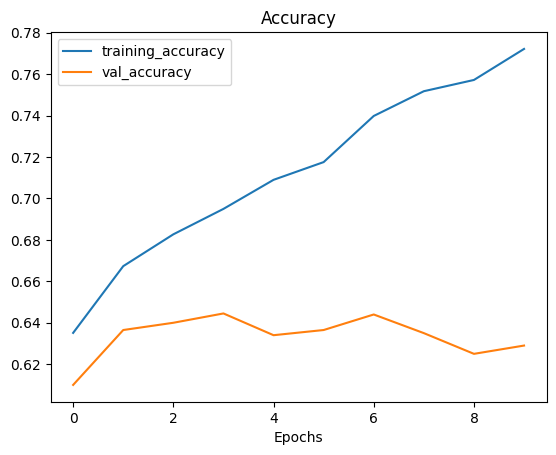

In [ ]:
plot_loss_curves(history_7)

## Eigth: Build CNN-LSTM Architecture
Trying Enhance On `model_7`

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# def build_hybrid_cnn_bilstm_model(vocab_size, embedding_dim, max_len, embedding_matrix=None):
#     input_ids = Input(shape=(max_len,), name='input_ids')

#     # Embedding layer
#     if embedding_matrix is not None:
#         embedding_layer = Embedding(input_dim=vocab_size,
#                                     output_dim=embedding_dim,
#                                     weights=[embedding_matrix],
#                                     input_length=max_len,
#                                     trainable=False)(input_ids)
#     else:
#         embedding_layer = Embedding(input_dim=vocab_size,
#                                     output_dim=embedding_dim,
#                                     input_length=max_len)(input_ids)
    
#     x = Conv1D(128 , 5 ,activation = 'relu')(embedding_layer)
#     x = MaxPooling1D(5)(x)

#     x = Conv1D(128 , 5 ,activation = 'relu')(x)
#     x = MaxPooling1D(5)(x)

#     x = Conv1D(128 , 5 ,activation = 'relu')(x)
#     x = MaxPooling1D(5)(x)

#     x = Flatten()(x)
#     x = Dense(250, activation='relu')(x)
#     x = Dense(250, activation='relu')(x)
#     output = Dense(3, activation='softmax')(x)



#     # # Convolutional layer
#     # conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
#     # pooling_layer = GlobalMaxPooling1D()(conv_layer)

#     # # Fully connected layers with Dropout and Batch Normalization
#     # x = Dropout(0.5)(pooling_layer)
#     # x = BatchNormalization()(x)
#     # x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#     # x = Dropout(0.5)(x)
#     # x = BatchNormalization()(x)
#     # output = Dense(3, activation='softmax')(x)  # Assuming 3 classes



#     # # CNN layer
#     # conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
#     # pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)
    
#     # # BiLSTM layer
#     # lstm_layer = Bidirectional(LSTM(units=100, return_sequences=True))(pooling_layer)
#     # lstm_layer = Bidirectional(LSTM(units=100))(lstm_layer)
    
#     # # Fully connected layers with Dropout and Batch Normalization
#     # x = Dropout(0.3)(lstm_layer)
#     # x = BatchNormalization()(x)
#     # x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#     # x = Dropout(0.3)(x)
#     # x = BatchNormalization()(x)
#     # output = Dense(3, activation='softmax')(x)  # Assuming 3 classes

#     model = Model(inputs=input_ids, outputs=output)
#     model.compile(optimizer=Adam(), 
#                   loss='sparse_categorical_crossentropy', 
#                   metrics=['accuracy'])
    
#     return model

def build_hybrid_cnn_bilstm_model(vocab_size, embedding_dim, max_len, embedding_matrix=None):
    input_ids = Input(shape=(max_len,), name='input_ids')

    # Embedding layer
    if embedding_matrix is not None:
        embedding_layer = Embedding(input_dim=vocab_size,
                                    output_dim=embedding_dim,
                                    weights=[embedding_matrix],
                                    input_length=max_len,
                                    trainable=False)(input_ids)
    else:
        embedding_layer = Embedding(input_dim=vocab_size,
                                    output_dim=embedding_dim,
                                    input_length=max_len)(input_ids)
    
    x = Conv1D(128, 5, activation='relu')(embedding_layer)
    x = MaxPooling1D(1)(x)  # Reduce pool size to avoid negative dimensions

    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(1)(x)  # Reduce pool size to avoid negative dimensions

    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(1)(x)  # Reduce pool size to avoid negative dimensions

    x = Flatten()(x)
    x = Dense(250, activation='relu')(x)
    x = Dense(250, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)

    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer=Adam(), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


# extracted the GloVe file
glove_file_path = 'glove.6B.100d.txt'
embedding_dim = 100
embedding_matrix = load_glove_embeddings(tokenizer, embedding_dim, glove_file_path)
vocab_size = embedding_matrix.shape[0]
embedding_dim = 100 
max_len = max_len  


model_8 = build_hybrid_cnn_bilstm_model(vocab_size, embedding_dim, max_len, embedding_matrix)
model_8.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 16)]              0         
                                                                 
 embedding_15 (Embedding)    (None, 16, 100)           6113400   
                                                                 
 conv1d_21 (Conv1D)          (None, 12, 128)           64128     
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 12, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_22 (Conv1D)          (None, 8, 128)            82048     
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 8, 128)            0         
 ng1D)                                                     

### Train The Model

In [56]:
# Import custom helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, get_callbacks

lr_scheduler, early_stopping = get_callbacks()

# Train the model
history_8 = model_8.fit(train_dataset,
                        epochs=20,
                        validation_data=val_dataset,
                        callbacks=[create_tensorboard_callback(dir_name="models_logs", # save experiment logs here
                                                            experiment_name="model_8_enhanced_pretraind_embeddings"), lr_scheduler])


Saving TensorBoard log files to: models_logs/model_8_enhanced_pretraind_embeddings/20240721-092730
Epoch 1/20


1939/1939 [==============================] - 21s 10ms/step - loss: 0.7810 - accuracy: 0.6364 - val_loss: 0.8280 - val_accuracy: 0.6170 - lr: 0.0010
Epoch 2/20
1939/1939 [==============================] - 19s 10ms/step - loss: 0.7078 - accuracy: 0.6855 - val_loss: 0.8209 - val_accuracy: 0.6370 - lr: 0.0010
Epoch 3/20
1939/1939 [==============================] - 14s 7ms/step - loss: 0.6635 - accuracy: 0.7105 - val_loss: 0.8183 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 4/20
1939/1939 [==============================] - 13s 7ms/step - loss: 0.6108 - accuracy: 0.7390 - val_loss: 0.8584 - val_accuracy: 0.6030 - lr: 0.0010
Epoch 5/20
1939/1939 [==============================] - 13s 7ms/step - loss: 0.5476 - accuracy: 0.7710 - val_loss: 0.9448 - val_accuracy: 0.6175 - lr: 0.0010
Epoch 6/20
1939/1939 [==============================] - 14s 7ms/step - loss: 0.4821 - accuracy: 0.8012 - val_loss: 1.0725 - val_accuracy: 0.5960 - lr: 0.0010
Epoch 7/20
1939/1939 [==============================] - 14s 7

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D, BatchNormalization, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_advanced_cnn_lstm_model(max_features, embedding_dim, max_len, embedding_matrix):
    """
    Build and compile an advanced CNN-LSTM model.

    Args:
        max_features (int): Size of the vocabulary.
        embedding_dim (int): Dimension of the embedding vectors.
        max_len (int): Maximum length of input sequences.
        embedding_matrix (numpy.ndarray): Pre-trained embedding matrix.

    Returns:
        Sequential: Compiled Keras model.
    """
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))  # Set trainable to False to use pre-trained embeddings
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 classes for multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

embedding_dim = 100
model_3 = build_advanced_cnn_lstm_model(max_features, embedding_dim, max_len, embedding_matrix)
model_3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16, 100)           6112800   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 16, 100)           0         
 alDropout1D)                                                    
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 128)           64128     
                                                                 
 batch_normalization (Batch  (None, 12, 128)           512       
 Normalization)                                                  
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 6, 128)            0         
 g1D)                                                            
                                                      

### Train The model

In [ ]:
# Train the model
history_3 = model_3.fit(X_train, y_train,
                        epochs=10,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[create_tensorboard_callback(dir_name="models_logs", # save experiment logs here
                                                            experiment_name="model_3_pretraind_embeddings"), lr_scheduler])


Saving TensorBoard log files to: models_logs/model_3_pretraind_embeddings/20240720-145441
Epoch 1/10
1939/1939 [==============================] - 44s 18ms/step - loss: 0.8102 - accuracy: 0.6202 - val_loss: 0.8205 - val_accuracy: 0.6135 - lr: 0.0010
Epoch 2/10
1939/1939 [==============================] - 25s 13ms/step - loss: 0.7673 - accuracy: 0.6539 - val_loss: 0.8151 - val_accuracy: 0.6210 - lr: 0.0010
Epoch 3/10
1939/1939 [==============================] - 22s 11ms/step - loss: 0.7491 - accuracy: 0.6629 - val_loss: 0.8085 - val_accuracy: 0.6255 - lr: 0.0010
Epoch 4/10
1939/1939 [==============================] - 22s 11ms/step - loss: 0.7353 - accuracy: 0.6699 - val_loss: 0.8043 - val_accuracy: 0.6295 - lr: 0.0010
Epoch 5/10
1939/1939 [==============================] - 21s 11ms/step - loss: 0.7248 - accuracy: 0.6779 - val_loss: 0.8041 - val_accuracy: 0.6380 - lr: 0.0010
Epoch 6/10
1939/1939 [==============================] - 30s 15ms/step - loss: 0.7129 - accuracy: 0.6840 - val_loss:

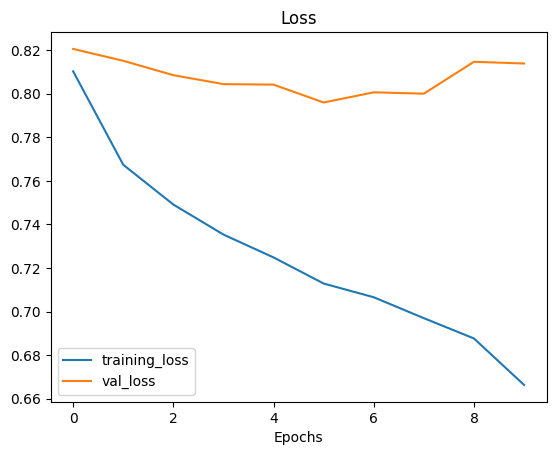

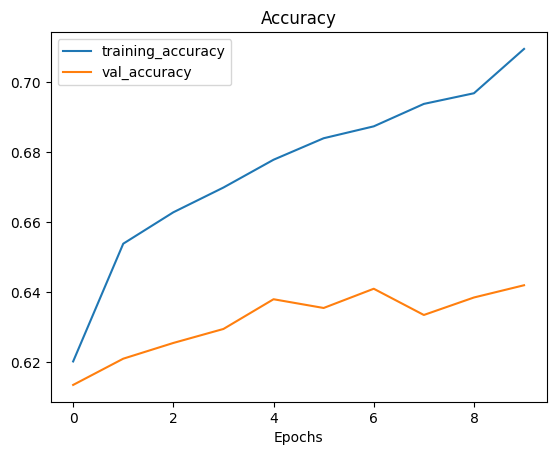

In [ ]:
plot_loss_curves(history_3)

## Track the Models

In [67]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [65]:
!kill 37184

In [69]:
# Start TensorBoard
%tensorboard --logdir models_logs

Reusing TensorBoard on port 6007 (pid 37633), started 0:01:54 ago. (Use '!kill 37633' to kill it.)